In [1]:
import tensorflow as tf
import os

print(tf.__version__)

2.0.0


In [2]:
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

#### VGG块的组成规律是：连续使用数个相同的填充为1、窗口形状为 3×3 的卷积层后接上一个步幅为2、窗口形状为 2×2 的最大池化层。卷积层保持输入的高和宽不变，而池化层则对其减半。我们使用vgg_block函数来实现这个基础的VGG块，它可以指定卷积层的数量num_convs和输出通道数num_channels

In [3]:
# 定义一个重复使用的vgg_block块

def vgg_block(net, num_convs, num_channels):
    # 参数说明：num_convs:卷积的个数，num_channels为卷积核的个数， num_convs个卷积核+maxpool2d
    for _ in range(num_convs):
        net.add(tf.keras.layers.Conv2D(num_channels,kernel_size=3,
                                    padding='same',activation='relu'))

    net.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return net


In [4]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [5]:
# 当然也可以自己自定义layer层，但是学会使用Sequential方式堆叠规范的层，更加简单方便

def vgg_net(conv_arch):
    vgg = tf.keras.models.Sequential()
    for n, k in conv_arch:
        vgg_block(vgg,n, k)
    # 注意 sequential.add() 可以直接添加一个叠加层，但是这个叠加层会作为一个整体,这里就逐个添加了，方便展示模型结构
#         net.add(tf.keras.models.Sequential([tf.keras.layers.Flatten(),
#              tf.keras.layers.Dense(4096,activation='relu'),
#              tf.keras.layers.Dropout(0.5),
#              tf.keras.layers.Dense(4096,activation='relu'),
#              tf.keras.layers.Dropout(0.5),
#              tf.keras.layers.Dense(10,activation='sigmoid')]))
    vgg.add(tf.keras.layers.Flatten())
    vgg.add(tf.keras.layers.Dense(4096,activation='relu'))
    vgg.add(tf.keras.layers.Dropout(0.5))
    vgg.add(tf.keras.layers.Dense(4096,activation='relu'))
    vgg.add(tf.keras.layers.Dropout(0.5))
    vgg.add(tf.keras.layers.Dense(10,activation='softmax'))
    return vgg

vgg = vgg_net(conv_arch)
vgg

In [6]:
X = tf.random.uniform((1,224,224,1))
for blk in vgg.layers:
    X = blk(X)
    print(blk.name, 'output shape:\t', X.shape)

conv2d output shape:	 (1, 224, 224, 64)
max_pooling2d output shape:	 (1, 112, 112, 64)
conv2d_1 output shape:	 (1, 112, 112, 128)
max_pooling2d_1 output shape:	 (1, 56, 56, 128)
conv2d_2 output shape:	 (1, 56, 56, 256)
conv2d_3 output shape:	 (1, 56, 56, 256)
max_pooling2d_2 output shape:	 (1, 28, 28, 256)
conv2d_4 output shape:	 (1, 28, 28, 512)
conv2d_5 output shape:	 (1, 28, 28, 512)
max_pooling2d_3 output shape:	 (1, 14, 14, 512)
conv2d_6 output shape:	 (1, 14, 14, 512)
conv2d_7 output shape:	 (1, 14, 14, 512)
max_pooling2d_4 output shape:	 (1, 7, 7, 512)
flatten output shape:	 (1, 25088)
dense output shape:	 (1, 4096)
dropout output shape:	 (1, 4096)
dense_1 output shape:	 (1, 4096)
dropout_1 output shape:	 (1, 4096)
dense_2 output shape:	 (1, 10)


#### 因为VGG-11计算上比AlexNet更加复杂，出于测试的目的我们构造一个通道数更小，或者说更窄的网络在Fashion-MNIST数据集上进行训练。

In [7]:
ratio = 8
# 将每个卷积层的输出通道数较少为 1/ 8
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg_net(small_conv_arch)

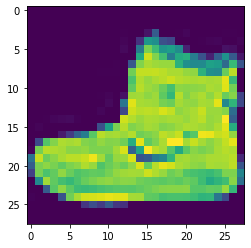

<Figure size 360x360 with 0 Axes>

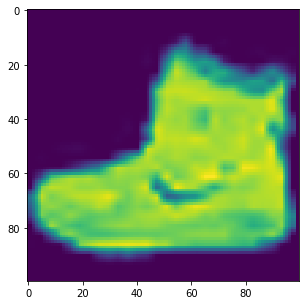

In [8]:
# 获取数据
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 熟悉一下，tf.image.resize_with_pad 函数
def resize(x):
    x = tf.cast(x, tf.float32)
    x = tf.reshape(x, (x.shape[0], x.shape[1], 1))
    x = tf.image.resize_with_pad(image=x, target_height=100, target_width=100, method='bilinear')
    x = tf.squeeze(x)
    return x

img = x_train[0]
img2 = resize(img)
plt.imshow(img)
plt.figure(figsize=(5,5))
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(img2)
plt.show()

In [9]:
# 数据预处理
def data_scale(x, y):
    x = tf.cast(x, tf.float32)
    x = x / 255.0
    x = tf.reshape(x, (x.shape[0], x.shape[1], 1))
    x = tf.image.resize_with_pad(image=x, target_height=224,target_width=224)
    
    return x, y
# 由于笔记本训练太慢了，使用1000条数据，跑一下先,算力够的可以直接使用全部数据更加明显
train_db = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(20).map(data_scale).batch(128)
test_db = tf.data.Dataset.from_tensor_slices((x_test,y_test)).shuffle(20).map(data_scale).batch(128)

In [10]:
# 定义优化器和损失函数
optimizer = tf.keras.optimizers.SGD(lr=1e-2)
loss = tf.keras.losses.sparse_categorical_crossentropy
net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [11]:
net.fit_generator(train_db, epochs=5, validation_data=test_db)    # 这里就不跑太多轮了，有机器可以自己调参跑个好的结果
net.summary()

Epoch 1/5
469/469 [==============================] - 48s 101ms/step - loss: 1.8138 - accuracy: 0.2021 - val_loss: 0.7817 - val_accuracy: 0.7026
Epoch 2/5
469/469 [==============================] - 47s 100ms/step - loss: 0.6934 - accuracy: 0.7119 - val_loss: 0.5400 - val_accuracy: 0.8040
Epoch 3/5
469/469 [==============================] - 47s 100ms/step - loss: 0.5256 - accuracy: 0.7980 - val_loss: 0.4749 - val_accuracy: 0.8274
Epoch 4/5
469/469 [==============================] - 47s 100ms/step - loss: 0.4574 - accuracy: 0.8284 - val_loss: 0.4213 - val_accuracy: 0.8492
Epoch 5/5
469/469 [==============================] - 47s 100ms/step - loss: 0.4156 - accuracy: 0.8454 - val_loss: 0.3834 - val_accuracy: 0.8611
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            multiple                  80        
____________________________________________________________

In [12]:
# net.save('vgg.h5')
X = tf.random.uniform((1,224,224,1))

for blk in net.layers:
    print('input shape:\t', X.shape)
    X = blk(X)
    print(blk.name, 'output shape:\t', X.shape)

input shape:	 (1, 224, 224, 1)
conv2d_8 output shape:	 (1, 224, 224, 8)
input shape:	 (1, 224, 224, 8)
max_pooling2d_5 output shape:	 (1, 112, 112, 8)
input shape:	 (1, 112, 112, 8)
conv2d_9 output shape:	 (1, 112, 112, 16)
input shape:	 (1, 112, 112, 16)
max_pooling2d_6 output shape:	 (1, 56, 56, 16)
input shape:	 (1, 56, 56, 16)
conv2d_10 output shape:	 (1, 56, 56, 32)
input shape:	 (1, 56, 56, 32)
conv2d_11 output shape:	 (1, 56, 56, 32)
input shape:	 (1, 56, 56, 32)
max_pooling2d_7 output shape:	 (1, 28, 28, 32)
input shape:	 (1, 28, 28, 32)
conv2d_12 output shape:	 (1, 28, 28, 64)
input shape:	 (1, 28, 28, 64)
conv2d_13 output shape:	 (1, 28, 28, 64)
input shape:	 (1, 28, 28, 64)
max_pooling2d_8 output shape:	 (1, 14, 14, 64)
input shape:	 (1, 14, 14, 64)
conv2d_14 output shape:	 (1, 14, 14, 64)
input shape:	 (1, 14, 14, 64)
conv2d_15 output shape:	 (1, 14, 14, 64)
input shape:	 (1, 14, 14, 64)
max_pooling2d_9 output shape:	 (1, 7, 7, 64)
input shape:	 (1, 7, 7, 64)
flatten_1 outp

conv2d_8 itput shape:	 (1, 224, 224, 1)
conv2d_8 output shape:	 (1, 224, 224, 8)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
max_pooling2d_5 itput shape:	 (1, 224, 224, 8)
max_pooling2d_5 output shape:	 (1, 112, 112, 8)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
conv2d_9 itput shape:	 (1, 112, 112, 8)
conv2d_9 output shape:	 (1, 112, 112, 16)
(112, 112)
(112, 112)
(112, 112)
(112, 112)
max_pooling2d_6 itput shape:	 (1, 112, 112, 16)
max_pooling2d_6 output shape:	 (1, 56, 56, 16)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
conv2d_10 itput shape:	 (1, 56, 56, 16)
conv2d_10 output shape:	 (1, 56, 56, 32)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
conv2d_11 itput shape:	 (1, 56, 56, 32)
conv2d_11 output shape:	 (1, 56, 56, 32)
(56, 56)
(56, 56)
(56, 56)
(56, 56)
max_pooling2d_7 itput shape:	 (1, 56, 56, 32)
max_pooling2d_7 output shape:	 (1, 28, 28, 32)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
conv2d_12 itput shape:	 (1, 28, 28, 32)
conv2d_12 output shape:	 (1, 28, 28, 64)
(28, 28)
(28, 28)
(28, 28)
(28, 28)

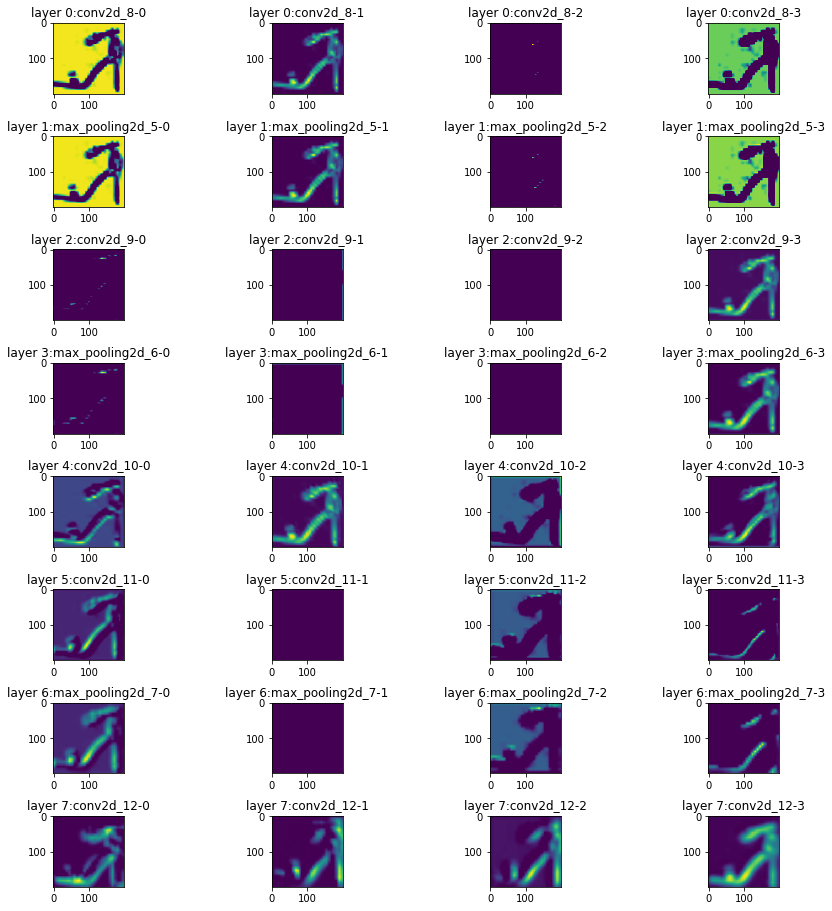

In [13]:
# 展示其中的前八层的特征图
X = next(iter(train_db))[0][0]

def show(X, k,i, name):
    print(X.shape)
    X = tf.expand_dims(X, axis=-1)
    # 将每个图转换为 200 * 200的像素，但这个不是图大小
    X = tf.image.resize(X,  [200,200], method='bilinear')
    X_ = tf.squeeze(X)
    t = plt.subplot(8, 4,  4*k + i + 1)
    t.title.set_text('layer %s:'%k + name + '-' + str(i))
    plt.imshow(X_)


X = tf.expand_dims(X, axis=0)

# 设置图纸大小
plt.figure(figsize=(15, 15))
# 打印前 8 层的部分特征图
for k,blk in enumerate(net.layers[0:8]):
    print(blk.name,'itput shape:\t',X.shape)
#     show(X[0,:,:,0])
    X = blk(X)

    print(blk.name, 'output shape:\t', X.shape)
    # 选择其中的四个通道
    for i in range(4):
        show(X[0,:,:,i], k, i, blk.name)
# 调整子图的间隔
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots,
               # expressed as a fraction of the average axis width
hspace = 0.6   # the amount of height reserved for white space between subplots,
               # expressed as a fraction of the average axis height

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top,
                wspace=wspace, hspace=hspace)


plt.show()